In [2]:
from torchvision import datasets
from torchvision import models
import torchvision.transforms as transforms
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader 
from tqdm import *
import json
from random import sample


## Получаем данные
Данные - это картинка и аннотации (до 4х) к ней. Будем использовать библиотеки torchvision для обработки визуальных данных
и torchtext для обработки текстовых данных

In [3]:
train_annotation = None
with open("../data/coco2017/annotations/captions_train2017.json") as f:
    train_annotation = json.load(f)

In [4]:
image_transforms = transforms.Compose([transforms.Resize([256, 256]), transforms.ToTensor()])

coco_ann_train_dataset = datasets.CocoCaptions("../data/coco2017/train2017/", 
                                               "../data/coco2017/annotations/captions_train2017.json",
                                              image_transforms)
coco_ann_val_dataset = datasets.CocoCaptions("../data/coco2017/val2017//", 
                                               "../data/coco2017/annotations/captions_val2017.json",
                                               image_transforms)


loading annotations into memory...
Done (t=1.22s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


Number of samples:  118287


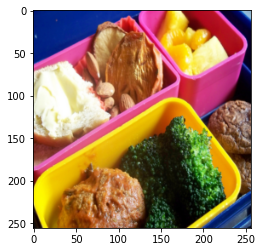

Image Size:  torch.Size([3, 256, 256])
00	Closeup of bins of food that include broccoli and bread.
01	A meal is presented in brightly colored plastic trays.
02	there are containers filled with different kinds of foods
03	Colorful dishes holding meat, vegetables, fruit, and bread.
04	A bunch of trays that have different food.


In [5]:
# выводим пример картинок из датасета и статистику датасета трейна 
print('Number of samples: ', len(coco_ann_train_dataset))

img, target = coco_ann_train_dataset[0] # load 4th sample

plt.imshow(img.permute(1, 2, 0))
plt.show()
print("Image Size: ", img.shape)
for i, t in enumerate(target):
    print ("%02d\t%s" %(i, t))

## Теперь нужно сформировать словарь для обучения RNN
Варианты формирования словаря: 
(Для описания элемента словаря, минимальной единицы измерения, используем термин токен)
1. Токен - слово 
2. Токен - буква или графема
3. буквенная n-грамма, или подслово (subword), имеются различные [алгоритмы разбиения на подслова](https://dyakonov.org/2019/11/29/%D1%82%D0%BE%D0%BA%D0%B5%D0%BD%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F-%D0%BD%D0%B0-%D0%BF%D0%BE%D0%B4%D1%81%D0%BB%D0%BE%D0%B2%D0%B0-subword-tokenization/)

In [6]:
tokenizer = get_tokenizer('basic_english')

In [7]:
# итераторы по тексту и токенам
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)
        
def yield_ann(ann_iter):
    for item in ann_iter:
         yield item["caption"]

In [8]:
# нам нужно добавить символы конца и начала последовательности 
senteces:list = [ s for s in train_annotation['annotations']]
senteces.insert(0, {'caption':'<s>'}) # символ начала последовательности
senteces.insert(1, {'caption':'</s>'}) # символ конца последовательности
vocab = build_vocab_from_iterator(yield_tokens(yield_ann(senteces)))

591755lines [00:08, 68657.53lines/s]


In [9]:
# получаем символы начала и конца придложения 
start_vocab_index = vocab['<s>']
end_vocab_index = vocab['</s>']
# в словаре по умолчанию добавляется еще два токена 
# <unk> - для техслов которые мы не знаем
# <pad> - для падинга последовательностей в батче

### Размером словаря будет определятся количество эмбединг векторов

In [10]:
"Vocab size: %d" %len(vocab)

'Vocab size: 28940'

## Определим какую визуальную модель.
Обученную визуальную модель можно взять из библиотеки torchvision: https://pytorch.org/vision/stable/models.html

In [11]:
visual_model= models.resnet34()
# тут убираем из визуальной модели последни слой классификатора, это для резнета, для другой модели возможно нужно будет 
# менять код
visual_model = torch.nn.Sequential(*(list(visual_model.children())[:-1]))

### Проверяем размерность выходного вектора, должно быть BxN 

In [12]:
context_vector_size = visual_model(img.unsqueeze(0)).shape[1]
"Context vector size: %d" %context_vector_size

'Context vector size: 512'

In [13]:
class CaptioningModel(nn.Module):
    
    def __init__(self, visual_model:nn.Module, # ссылка на контекстную модель  
                       context_vector_size:int, # размер вектора контекста  
                       rnn_hidden_size,  # размер скрытого слоя rnn (h)
                       input_vector_size, # размер входного вектора, размер векктора эмбедингов
                       start_end_seq,  # символы начала и конца последовательности
                       vocabular_size  # размер словаря
                ):
        super().__init__()
        # входные эмбединги 
        self.input_embeddings = nn.Embedding(num_embeddings=vocabular_size, 
                                             embedding_dim=input_vector_size)
        self._vis_model = visual_model
        self._context_transform = nn.Linear(context_vector_size, rnn_hidden_size) # слой для афинного преобразование контекста
        self._rnn = nn.LSTM(input_vector_size, rnn_hidden_size, batch_first=True)
        self._output_layer = nn.Linear(rnn_hidden_size, vocabular_size)
        self._start_end_seq = start_end_seq
        #self.softmax = nn.Softmax(2)
        
    def forward(self, image: torch.Tensor, texts: torch.Tensor = None)-> torch.Tensor:
        """
        Ворвард должен уметь работать как в режиме обучения с учителем (teacher forcing)
        так и в инкрементальном режимt
        Возвращаем предсказанные строки 
        """
        # получаем контекст:
        ctx:torch.Tensor = self._context_transform.forward( self._vis_model(image).squeeze(-1).squeeze(-1) )
        # нужно добавить еще одну размерность по времени
        ctx = ctx.unsqueeze(0)
        out_tensor:torch.Tensor = None
        if texts is None:
            out_tensor = self._incremental_forward(ctx)
        else:
            # режим форсирования учителя
            embedded_texts = self.input_embeddings(texts)
            rnn_out, _ = self._rnn(embedded_texts, (ctx, ctx))
            out_tensor = self._output_layer(rnn_out)  
                        
            
        return out_tensor
        
    def _incremental_forward(self, ctx: torch.Tensor) -> torch.Tensor:
        max_steps = 30
        output = []
        # созданем торч тензор для первого символа 
        cur_symbol = self._start_end_seq[0]
        hidden = (ctx, ctx)
        output_string = [self._start_end_seq[0]]
        for i in range(0, max_steps):
            cur_state = torch.LongTensor([cur_symbol]).unsqueeze(0).to(ctx.device)
            cur_state = self.input_embeddings(cur_state) # получим эмбединг символа
            rnn_output, hidden = self._rnn(cur_state, hidden)
            out_tensor = self._output_layer(rnn_output)
            cur_symbol = int(torch.argmax(softmax(out_tensor, dim=-1), dim=-1).squeeze(0)[0])
            output_string += [cur_symbol]
            if cur_symbol == self._start_end_seq[1]: break
        return output_string
            
            
    def parameters(self):
        """
        Переопределяем этот метод, для того чтобы заморозить параметры сети обработки изображений
        """

        def _disable_gradient(parent: torch.nn.Module) -> None:
            for child in parent.children():
                c: torch.nn.Module = child
                params = c.parameters()
                if params is not None:
                    for param in params:
                        param.requires_grad = False

                if 'children' in dir(child):
                    _disable_gradient(child)

        _disable_gradient(self._vis_model)

        return super().parameters()


## Определение процедуры загрузки и обработки данных
Для этого используются две сущности DataSet - описывает данные, у нас уже он сформирован из библиотеки торча, и DataLoader - определляет, определяющий методику работы с датасетом. Поскольку у нас нестандартный датасет вида тензор - тензор, нам нужно определить свою функцию collate для формирования батча из картинки как инпута нейросети, и строк как отпута нейросети. 

Для формирования батча из набора строк нам нужно 
1. перевести строки в тензора, где каждый элемент тензора это id в словаре
2. каждая строка должна содержать символ начала и конца
2. так как у нас длинны строк разные, то мы должны их выравнять  

In [14]:
def collate(batch_items):
    # сюда приходит список пар тензор картинки, и список строк описания
    max_length = 0
    tensored_data = []
    pad_value = vocab['<pad>']
    images_tensor = []
    rows_tensor = []
    for b_item in batch_items:
        # 
        img, rows = b_item
        images_tensor += [img.unsqueeze(0)]
        # нам нужно перевести тексты в тензор который будет содержать список id 
        # для обучения, нам нужен только один пример, поэтому семплируем рандомно одну строчку
        row = sample(rows,1)[0]
        row = "<s> %s </s>" %row
        # переводим строку в список индексов, а потом с тензор с доп размерностью, 
        idx = torch.LongTensor([ vocab[t] for t in tokenizer(row)])
        max_length = max(max_length, len(row))
        rows_tensor  += [idx]
    
    # терперь нам нужно западить все последовательности которые меньше чем  max_length
    # в тензорах последовательностей, нужно для того, что бы мы могли сформировать батч 
    # для последовательностей ращной длинны
    rows_tensor = pad_sequence(rows_tensor, batch_first=True, padding_value=pad_value)
    # возвращаем тензора картинок и строк к ним
    return torch.cat(images_tensor, dim=0), rows_tensor

In [15]:
train_data_loader = DataLoader(coco_ann_train_dataset, 64, True, num_workers=10, collate_fn = collate )

In [16]:
val_data_loader = DataLoader(coco_ann_val_dataset, 64, False, num_workers=10, collate_fn = collate )

In [17]:
caption_model = CaptioningModel(visual_model=visual_model, 
                                context_vector_size=context_vector_size,
                                rnn_hidden_size=1024,
                                input_vector_size = 512,
                                start_end_seq = (vocab["<s>"], vocab["</s>"]),
                                vocabular_size=len(vocab)
                                )
caption_model = caption_model.cuda()
optimizer = Adam(caption_model.parameters(), lr=1e-4)
loss = nn.CrossEntropyLoss()

In [18]:
# инициализируем тензорборд, для вывода графиков
writer = SummaryWriter(log_dir='./runs/')

In [25]:
def test_model(epoch):
    test_iter  = tqdm(val_data_loader)
    sum_loss = 0
    num_batches = 0
    for i, batch in enumerate(test_iter):
        batch_loss, text = forward_model(batch)
        sum_loss += batch_loss
        num_batches += 1
    sum_loss /= num_batches
    writer.add_scalar('Loss/val', sum_loss , epoch)
    writer.add_text('Val', text , epoch)
    return sum_loss

def output_to_text(model_out):
    return ' '.join([ vocab.itos[i] for i in torch.argmax(softmax(model_out, dim=2), dim=-1)[0] if i != 1])
 
    
pad_value = vocab['<pad>']
def forward_model(batch):
        image, strings = batch
        image = image.cuda()
        strings = strings.cuda()
        model_out = caption_model.forward(image, strings)
        model_text = output_to_text(model_out)
        # таргет должен быть смещен на 1 временной семпл вправо, 
        # так как, мы должны предсказывать следующий терм в последовательности
        # обрезаем <s> и добавляем паддинг
        target_strings = strings[:,1:] 
        # и добавим слева паддинги
        padded = torch.zeros([strings.shape[0],1], dtype=torch.long).fill_(pad_value).to(strings.device)
        target_strings = torch.cat([target_strings, padded], dim=1) 
        batch_loss = loss(model_out.transpose(2,1), target_strings)
        return batch_loss, model_text
    

In [21]:
global_iter = 0
global_epoch = 0

In [ ]:
# тренируем модель
best_test_Loss = 100 
for epoch in range(0,1000):
    sum_loss = 0
    epoch_iter  = tqdm(train_data_loader)
    for i, batch in enumerate(epoch_iter):
        optimizer.zero_grad()
        batch_loss, test_text = forward_model(batch)        
        batch_loss.backward()
        sum_loss += batch_loss
        epoch_iter.set_description("Epoch: %04d, Iter Loss: %.4f"  %(epoch, batch_loss))
        optimizer.step()
        if ( global_iter % 50 ) == 0:
            writer.add_scalar('Loss/train', batch_loss , global_iter)
            _, strings = batch
            target_text = ' '.join ([ vocab.itos[idx] for idx in strings[0] if idx != 1 ] )
            writer.add_text('Train', "t: %s / m: %s" %(target_text, test_text), global_iter)
        global_iter += 1
    with torch.no_grad():
        test_loss = test_model(global_epoch)
        if test_loss < best_test_Loss:
            torch.save(caption_model.state_dict(), 'best_caption_model.ptx')
            best_test_Loss = test_loss
    global_epoch += 1

Epoch: 0005, Iter Loss: 1.4353:  97%|█████████▋| 1790/1849 [05:57<00:12,  4.64it/s]

In [1]:
# сохраним веса модели
torch.save(caption_model.state_dict(), 'caption_model.ptx')

NameError: name 'torch' is not defined

In [30]:
infer_caption_model = CaptioningModel(visual_model=visual_model, 
                                      context_vector_size=context_vector_size,
                                      rnn_hidden_size=1024,
                                      input_vector_size = 512,
                                      start_end_seq = (vocab["<s>"], vocab["</s>"]),
                                      vocabular_size=len(vocab)
                                     )

infer_caption_model.load_state_dict(torch.load('caption_model.ptx'))

<All keys matched successfully>

In [31]:
def infer_model(img, model, vocab):
    output  =  model.forward(img, None)
    print(' '.join([vocab.itos[i] for i in output]) )


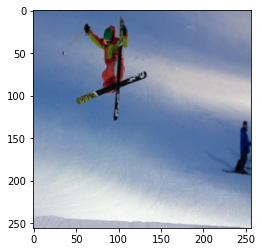

<s> a man and a woman are standing next to each other </s>


In [42]:
infer_caption_model = infer_caption_model.cuda()
sample = coco_ann_val_dataset[302]
img, texts = sample
plt.imshow(img.permute(1, 2, 0))
plt.show()
img = img.unsqueeze(0).cuda()
infer_model(img, infer_caption_model, vocab)


In [50]:
torch.zeros([1,2])

tensor([[0., 0.]])